In [5]:
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

## Strip Detection & Comparison

This script takes a raw picture of the strips, detects the sensible regions of the strips, and compares all the strips with the right-most which is asummed to be the water control.

2190


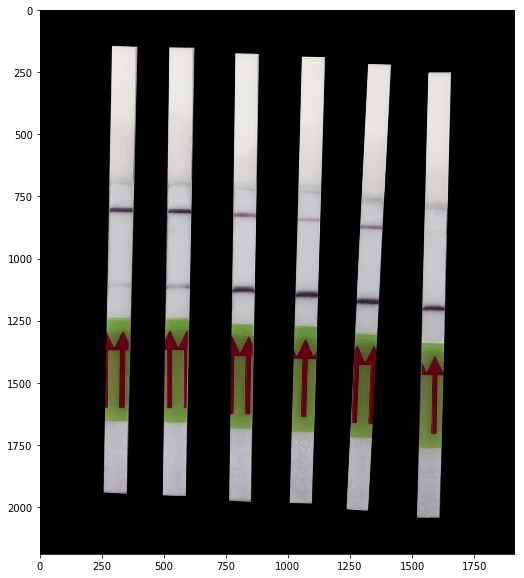

In [27]:
# filename = 'images/strips6.jpg'
filename = 'images/strips12c.jpg'
# filename = 'images/strips13a.jpg'
# filename = 'images/strips13c.jpg'
image = cv2.imread(filename)
image = cv2.GaussianBlur(image, (5,5), 0)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [44]:
# Parameters - All of these should normalized as a function of the image resolution and 
# expected size of the strips

w = image.shape[0]
h = image.shape[1]

# The Y value above which the top of the strip should be 
maxTopY = int(w * 0.2)

# The Y value above which the begining of the sensitive part of the strip should be
maxCenterY = int(w * 0.65)

# Minimum area of the colored center box in the strip
minCenterBoxArea = 10000

# Minimum area of the top strip boxes
minTopBoxArea = 30000

# Minimum intensity for binary thresholding of the top portion of the strips
minStripThreshold = 190

# Sensitive area of the strip
stripWidth = 200
stripHeight = 2000
stripHoldY = 950

# Percentage of the margins to be removed
marginFraction = 0.2


print(maxTopY)
print(maxCenterY)

438
1423


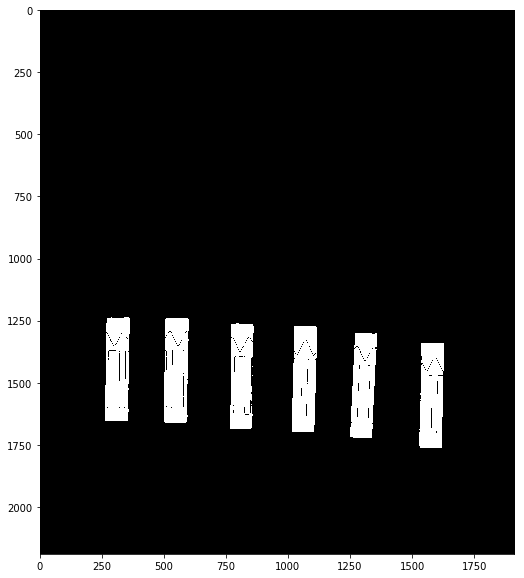

In [35]:
# Processing Step 1: detecting the colored area in the strips

# First, convert the image to HSV color space, which makes the color detection straightforward
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# These strips have red arrows on a green background, so we define two masks, one for red and the other for green

# Red is at the beginning/end of the hue range, so it covers the [0-10] and the [170, 180] (hue in OpenCV varies
# between 0 and 180 degrees)
lower_red = np.array([0, 50, 50]) 
upper_red = np.array([10, 255, 255]) 
red_mask1 = cv2.inRange(hsv, lower_red, upper_red) 

lower_red = np.array([170, 50, 50]) 
upper_red = np.array([180, 255, 255]) 
red_mask2 = cv2.inRange(hsv, lower_red, upper_red) 

red_mask = red_mask1 + red_mask2

# Green is between 20 and 90 (these ranges can be adjusted)
lower_green = np.array([20, 50, 50]) 
upper_green = np.array([90, 255, 255]) 
green_mask = cv2.inRange(hsv, lower_green, upper_green)

mask = red_mask + green_mask

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

1423 1337
Found suitable center box
36322.0
[[1617 1764]
 [1524 1761]
 [1534 1337]
 [1627 1339]]
1423 1296
Found suitable center box
36664.0
[[1337 1724]
 [1246 1720]
 [1267 1296]
 [1357 1301]]
1423 1269
Found suitable center box
37288.0
[[1104 1700]
 [1012 1697]
 [1023 1269]
 [1115 1272]]
1423 1261
Found suitable center box
33671.5
[[ 854 1685]
 [ 764 1684]
 [ 770 1261]
 [ 859 1262]]
1423 1237
Found suitable center box
37193.0
[[ 593 1661]
 [ 497 1660]
 [ 504 1237]
 [ 599 1238]]
1423 1235
Found suitable center box
37464.0
[[ 355 1656]
 [ 259 1654]
 [ 267 1235]
 [ 363 1237]]


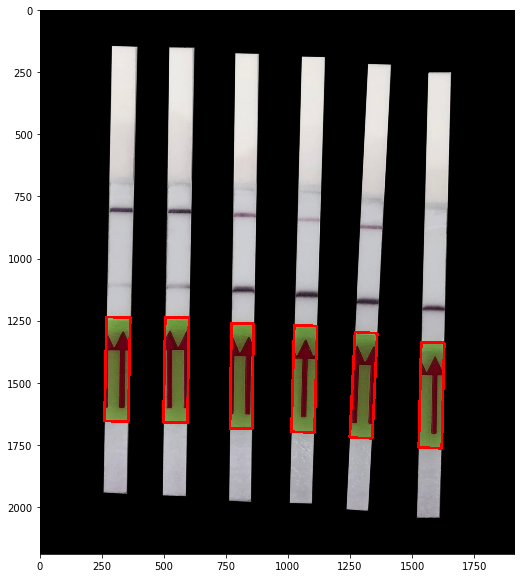

In [45]:
# Processing Step 2: determining the bounding boxes for the colored areas

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

center_boxes = []
for c in cnts:
    area = cv2.contourArea(c)
    M = cv2.moments(c)
    if area < minCenterBoxArea or M["m00"] == 0: continue
        
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    minBoxY = min(box[0][1], box[1][1], box[2][1], box[3][1])    
    if maxCenterY < minBoxY: continue
        
    print("Found suitable center box")
    print(area)    
    print(box)
    center_boxes += [box]
    
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

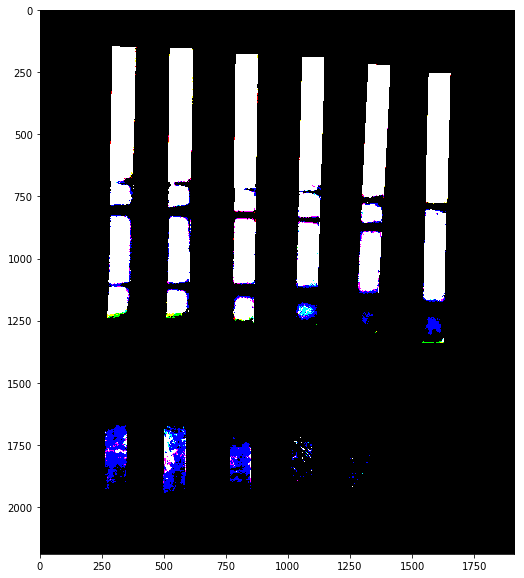

In [46]:
# Processing Step 3: binary thresholding of the entire image to extract the top part of the strips
ret, thresh = cv2.threshold(image, minStripThreshold, 255, cv2.THRESH_BINARY)

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

Found suitable top box
438 250
Found suitable top box
438 216
Found suitable top box
438 188
Found suitable top box
438 175
Found suitable top box
438 151
Found suitable top box
438 145


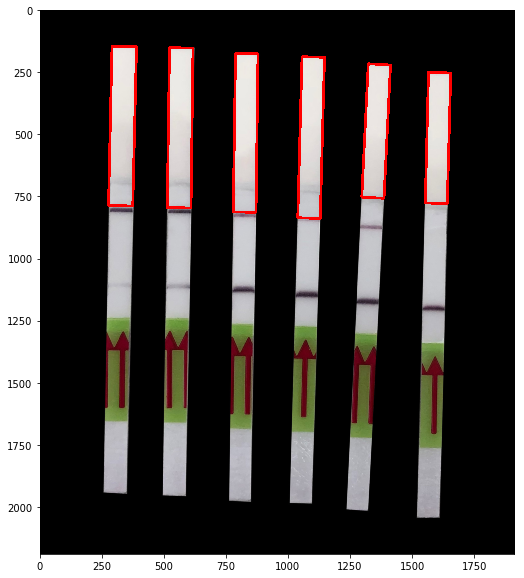

In [76]:
# Processing Step 4: detect boundary boxes for the top of the strips

grayscale = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

top_boxes = []
for c in cnts:
    area = cv2.contourArea(c)
    M = cv2.moments(c)    
    if area < minTopBoxArea or M["m00"] == 0: continue

    # Parameters for 13c only
#     if area < minTopBoxArea/10 or M["m00"] == 0: continue
        
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    minBoxY = min(box[0][1], box[1][1], box[2][1], box[3][1]) 
    if maxTopY < minBoxY: continue

    # Parameters for 13c only
#     if 200 < box[1][1] or 200 < box[2][1]: continue

    print("Found suitable top box")
    print(maxTopY, minBoxY)
#     print(area)    
#     print(box)
    top_boxes += [box]
    
    tmp = cv2.drawContours(tmp, [box], 0, (0,0,255), 10)
    
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [94]:
# From:
# https://www.cs.hmc.edu/ACM/lectures/intersections.html
    
def intersectLines(pt1, pt2, ptA, ptB): 
    """ this returns the intersection of Line(pt1,pt2) and Line(ptA,ptB)
        
        returns a tuple: (xi, yi, valid, r, s), where
        (xi, yi) is the intersection
        r is the scalar multiple such that (xi,yi) = pt1 + r*(pt2-pt1)
        s is the scalar multiple such that (xi,yi) = pt1 + s*(ptB-ptA)
            valid == 0 if there are 0 or inf. intersections (invalid)
            valid == 1 if it has a unique intersection ON the segment    """

    DET_TOLERANCE = 0.00000001

    # the first line is pt1 + r*(pt2-pt1)
    # in component form:
    x1, y1 = pt1;   x2, y2 = pt2
    dx1 = x2 - x1;  dy1 = y2 - y1

    # the second line is ptA + s*(ptB-ptA)
    x, y = ptA;   xB, yB = ptB;
    dx = xB - x;  dy = yB - y;

    # we need to find the (typically unique) values of r and s
    # that will satisfy
    #
    # (x1, y1) + r(dx1, dy1) = (x, y) + s(dx, dy)
    #
    # which is the same as
    #
    #    [ dx1  -dx ][ r ] = [ x-x1 ]
    #    [ dy1  -dy ][ s ] = [ y-y1 ]
    #
    # whose solution is
    #
    #    [ r ] = _1_  [  -dy   dx ] [ x-x1 ]
    #    [ s ] = DET  [ -dy1  dx1 ] [ y-y1 ]
    #
    # where DET = (-dx1 * dy + dy1 * dx)
    #
    # if DET is too small, they're parallel
    #
    DET = (-dx1 * dy + dy1 * dx)

    if math.fabs(DET) < DET_TOLERANCE: return (0,0,0,0,0)

    # now, the determinant should be OK
    DETinv = 1.0/DET

    # find the scalar amount along the "self" segment
    r = DETinv * (-dy  * (x-x1) +  dx * (y-y1))

    # find the scalar amount along the input line
    s = DETinv * (-dy1 * (x-x1) + dx1 * (y-y1))

    # return the average of the two descriptions
    xi = (x1 + r*dx1 + x + s*dx)/2.0
    yi = (y1 + r*dy1 + y + s*dy)/2.0
    return ( xi, yi, 1, r, s )

def getOrderedBoxCorners(box):
    # TODO: makes this generic, now the order is hard-coded
    
#     y = []
#     for b in box:
#         y += [b[1]]
#     ymean = np.mean(y)
#     print(ymean)
    
#     for b in box:
#         if b[1] < ymean
#             print
    
    c0 = box[1] # botton left corner
    c1 = box[2] # top left corner   
    c2 = box[3] # top right corner 
    c3 = box[0] # bottom right corner      
    
    return c0, c1, c2, c3    

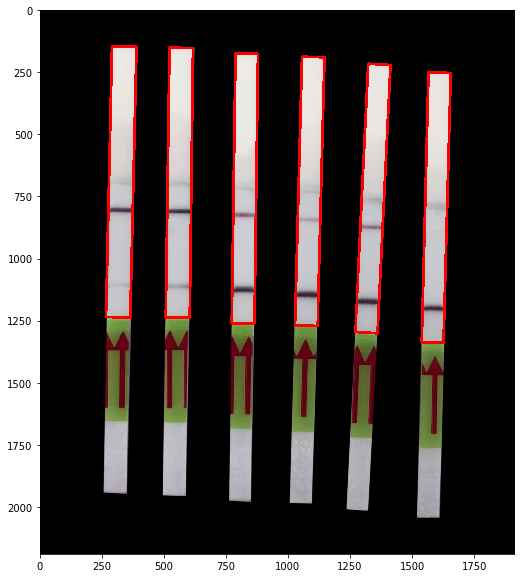

In [95]:
# Processing Step 5: construct the boxes that enclose the sensitive strip area

# First, order the top and center boxes from left to right
top_boxes.sort(key=lambda box: box[0][0], reverse=False)
center_boxes.sort(key=lambda box: box[0][0], reverse=False)

# Create a copy of the original image to draw the bounding boxes on
tmp = image.copy()

assert(len(top_boxes) == len(center_boxes)), "Different number of top and center boxes"

num_boxes = len(top_boxes)

strip_boxes = []

for i in range(0, num_boxes):
    tbox = top_boxes[i]
    cbox = center_boxes[i]    

    # The corners are expected to be received in the following order:
    # 0 = botton left corner
    # 1 = top left corner   
    # 2 = top right corner 
    # 3 = bottom right corner   
    tp0, tp1, tp2, tp3 = getOrderedBoxCorners(tbox)
    cp0, cp1, cp2, cp3 = getOrderedBoxCorners(cbox)
    
    # The intersection of the lines defining the sides of the strip (tp1-tp0 and tp2-tp3)
    # with the top edge of the center box defines the bottom corners of the area of interest
    res1 = intersectLines(tp1, tp0, cp1, cp2)
    res2 = intersectLines(tp2, tp3, cp1, cp2)    
    
    assert(res1[2] == 1 and res2[2] == 1), "Top and center boxes are not intersecting"
    
    p1 = np.array([int(round(res1[0])), int(round(res1[1]))])
    p2 = np.array([int(round(res2[0])), int(round(res2[1]))])
    
    sbox = np.array([p1, tp1, tp2, p2])
#     sbox = np.array([cp1, tp1, tp2, cp2])
    
    strip_boxes += [sbox]
    tmp = cv2.drawContours(tmp, [sbox], 0, (0, 0, 255), 10)
        
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [89]:
# Processing Step 6: Extract the strips into separate images

ref_box = np.array([[0, 0],[0, stripHeight],[stripWidth, stripHeight],[stripWidth, 0]], dtype=float)

raw_strip_images = []
for sbx in strip_boxes:
    h, status = cv2.findHomography(sbx, ref_box)
    img = cv2.warpPerspective(image, h, (stripWidth, stripHeight))
    raw_strip_images += [img]

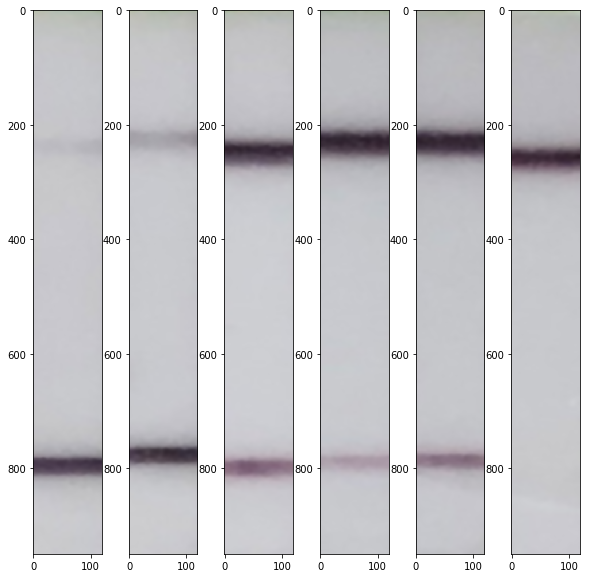

In [90]:
# Processing Step 7: Crop the images to remove the grip of the strips, and the vertical borders

norm_strip_images = []

fig, plots = plt.subplots(1, len(raw_strip_images))
idx = 0
for img in raw_strip_images:
    # Crop out the top and the bottom parts of the strip, and applying bilateral filtering for smoothing
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    x0 = int(marginFraction * stripWidth)
    x1 = int((1 - marginFraction) * stripWidth)
    y0 = 0
    y1 = stripHoldY

    crop = img[y0:y1, x0:x1]
    nimg = cv2.bilateralFilter(crop, 9, 75, 75)
    norm_strip_images += [nimg]
    
    plots[idx].imshow(cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB))
    idx += 1

Found peak in control at 347 with a value of 199.26944444444445
Found peak in test 1 at 315 with a value of 65.47777777777777
Need to align peaks by -32
Found peak in test 2 at 297 with a value of 56.605555555555554
Need to align peaks by -50
Found peak in test 3 at 320 with a value of 117.525
Need to align peaks by -27
Found peak in test 4 at 311 with a value of 164.0
Need to align peaks by -36
Found peak in test 5 at 309 with a value of 124.70833333333333
Need to align peaks by -38


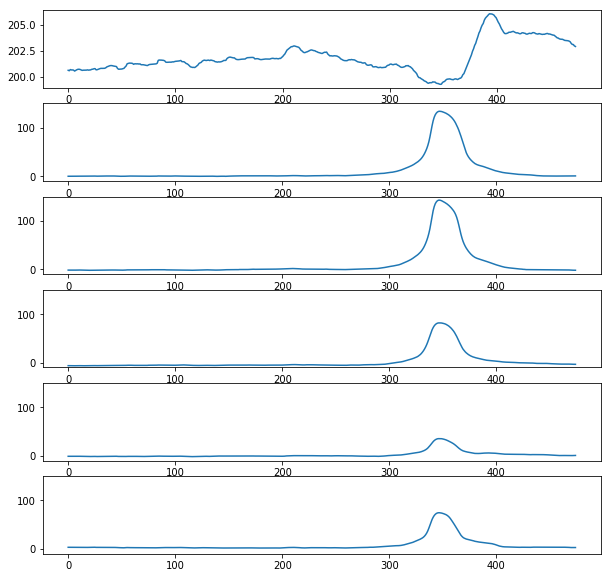

In [91]:
# Processing Step 8: Compare all test images with the control image (last)

def getPeak(data, start):
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):    
        values = np.append(values, np.mean(data[r]))
    
    v = values[start:-1]
    mean = np.mean(v[0:int(len(v)/2)])
    std = np.std(v[0:int(len(v)/2)])
    
    i = np.argmin(v)    
    peak = np.min(v)
    if peak < mean - 3 * std:
        return i, peak, v     
    else:
        return None, None, v

ctrl_img = norm_strip_images[-1]

# Convert from uint8 to int32 so we can get negative values
ctrl_data = ctrl_img.astype('int32')
half = int(ctrl_data.shape[0]/2)
ctrl_pk_idx, ctrl_pk_val, ctrl_all_val = getPeak(ctrl_data, half)
if ctrl_pk_idx:
    print("Found peak in control at", ctrl_pk_idx, "with a value of", ctrl_pk_val)
else:
    print("No peak found in control")
    
fig, plots = plt.subplots(len(norm_strip_images))
# plots[0].set_ylim([180, 220])
plots[0].plot(ctrl_all_val)

idx = 1
for test_img in norm_strip_images[0:-1]:
    test_data = test_img.astype('int32')        
    test_pk_idx, test_pk_val, test_all_val = getPeak(test_data, half)
    
    if test_pk_idx:
        print("Found peak in test", idx, "at", test_pk_idx, "with a value of", test_pk_val)
    else:
        print("No peak found in test", idx)
        
    if test_pk_idx and ctrl_pk_idx and test_pk_idx != ctrl_pk_idx:
        idx_diff = test_pk_idx - ctrl_pk_idx
        print("Need to align peaks by", idx_diff)

        # Very inefficient way of doing this... 
        rows = []
        for i in range(half, ctrl_data.shape[0]):
            if i + idx_diff < test_data.shape[0]:
                d = ctrl_data[i] - test_data[i + idx_diff]
                rows.append(d)
                
        diff = np.array(rows)
    else:
        # No alignment is needed
        diff = ctrl_data - test_data
        diff = diff[half:-1]
        
    # Another possibility could be to use OpenCV's image integrals:
    # http://www.aishack.in/tutorials/integral-images-opencv/

    values = np.array([]) 
    nrows = diff.shape[0]    
    for r in range(0, nrows):
        values = np.append(values, np.mean(diff[r]))

    plots[idx].set_ylim([-10, 150])
    plots[idx].plot(values)
    idx += 1

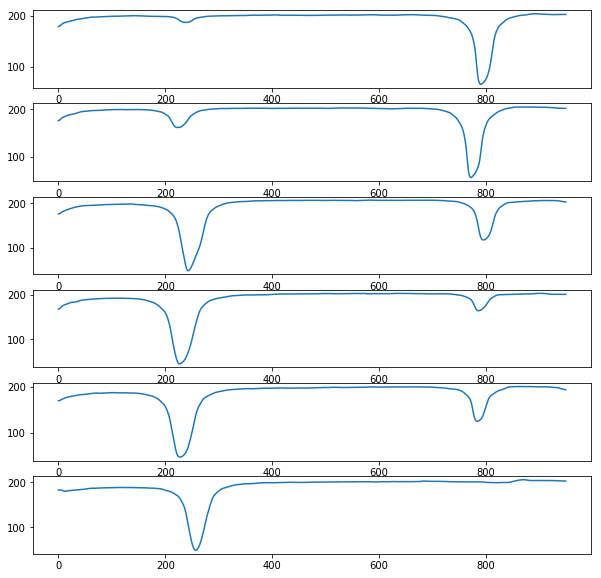

In [83]:
fig, plots = plt.subplots(len(norm_strip_images))
idx = 0
for img in norm_strip_images:
    data = img.astype('int32') 
    nrows = data.shape[0]
    values = np.array([])
    for r in range(0, nrows):    
        values = np.append(values, np.mean(data[r]))    
    plots[idx].plot(values)
#     print(np.argmin(values[0:half]))
#     print(np.argmin(values[half:-1]))
    idx += 1    